In [1]:
import os
import time

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import matplotlib as mlib

import pandas as pd
import numpy as np

from IPython import display

In [2]:
%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 8)

In [4]:
tf.__version__

'2.5.0'

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*32, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 32)))
    assert model.output_shape == (None, 7, 7, 32)

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [10]:
generator = make_generator_model()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1568)              156800    
_________________________________________________________________
batch_normalization (BatchNo (None, 1568)              6272      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1568)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 16)          12800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 16)          0

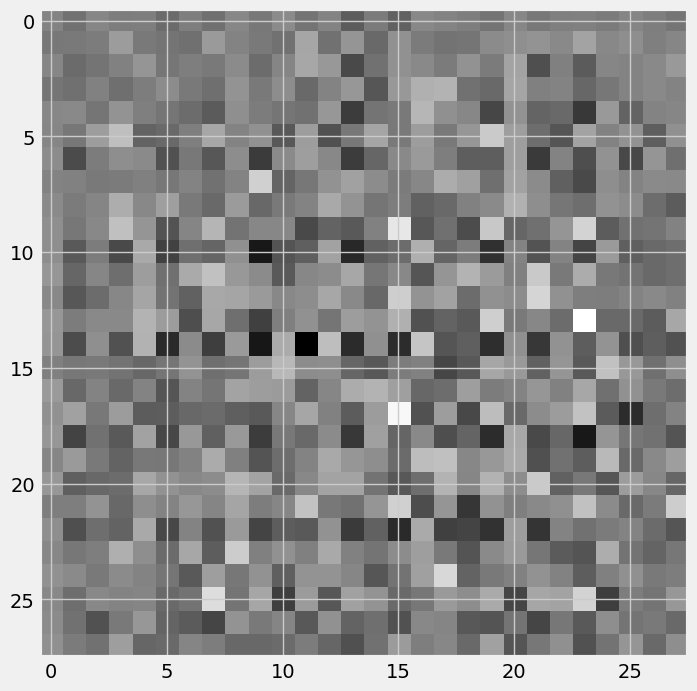

In [12]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)             

In [15]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.01060953]], shape=(1, 1), dtype=float32)


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [23]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [24]:
def train(dataset, epochs):
    res_metrics = pd.DataFrame(columns=['epoch', 'batch', 'gen_loss', 'disc_loss'])

    for epoch in range(epochs):
        start = time.time()

        for i, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            to_append = {
                'epoch': epoch,
                'batch': i,
                'gen_loss': gen_loss.numpy(),
                'disc_loss': disc_loss.numpy()
                }
            res_metrics = res_metrics.append(to_append, ignore_index=True)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch+1} is: {time.time()-start:.0f} seconds,'
              f' generator loss: {gen_loss:.2f}, discriminator loss: {disc_loss:.2f}.')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    return res_metrics

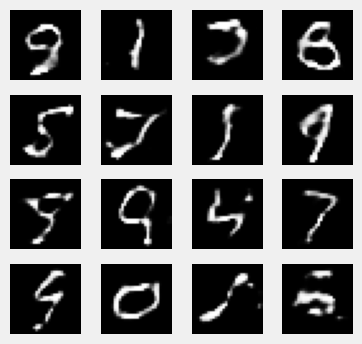

In [25]:
res_metrics = train(train_dataset, EPOCHS)

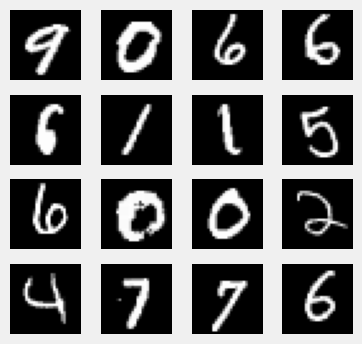

In [26]:
fig = plt.figure(figsize=(4, 4))
for i, e in enumerate(train_dataset.unbatch().take(16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(e[:, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

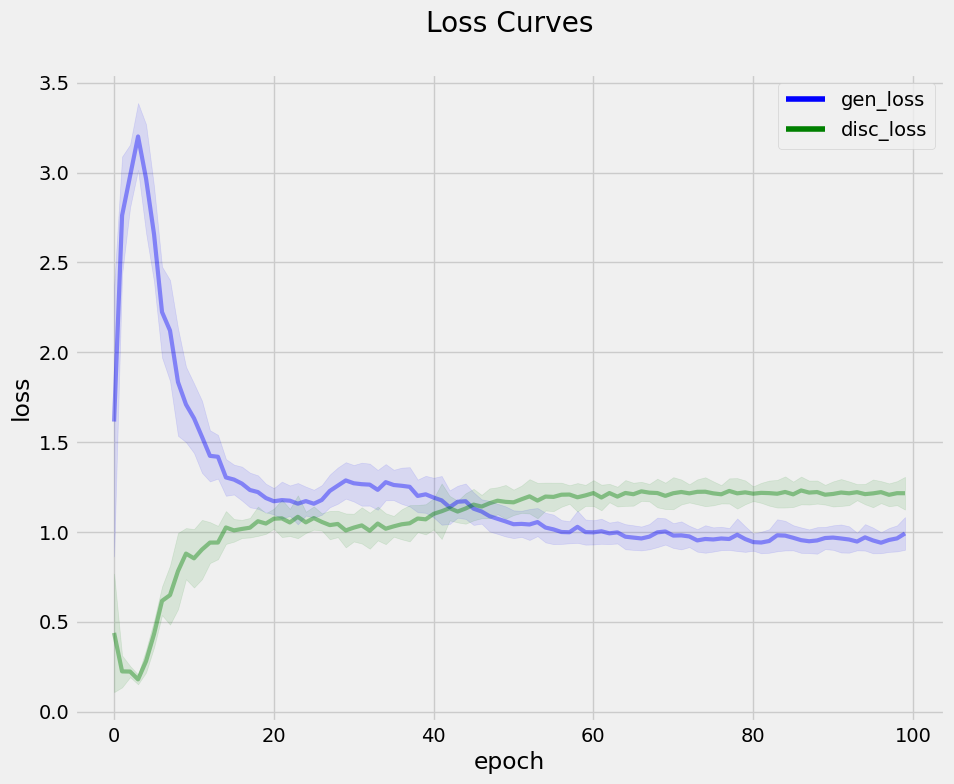

In [43]:
epochs = sorted(res_metrics.epoch.unique().tolist())
legend_handles = []

for c, l in zip(['b', 'g'], ['gen_loss', 'disc_loss']):
    mean = res_metrics.groupby('epoch').agg(['mean', 'std'])[l]['mean']
    std = res_metrics.groupby('epoch').agg(['mean', 'std'])[l]['std']

    plt.fill_between(epochs, mean-std, mean+std, color=c, alpha=0.1)
    plt.plot(mean, c=c, linewidth=3, alpha=0.4,)
    legend_handles.append(mlib.lines.Line2D([], [], color=c, label=l))

plt.legend(handles=legend_handles)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss Curves', pad=30)

plt.show()

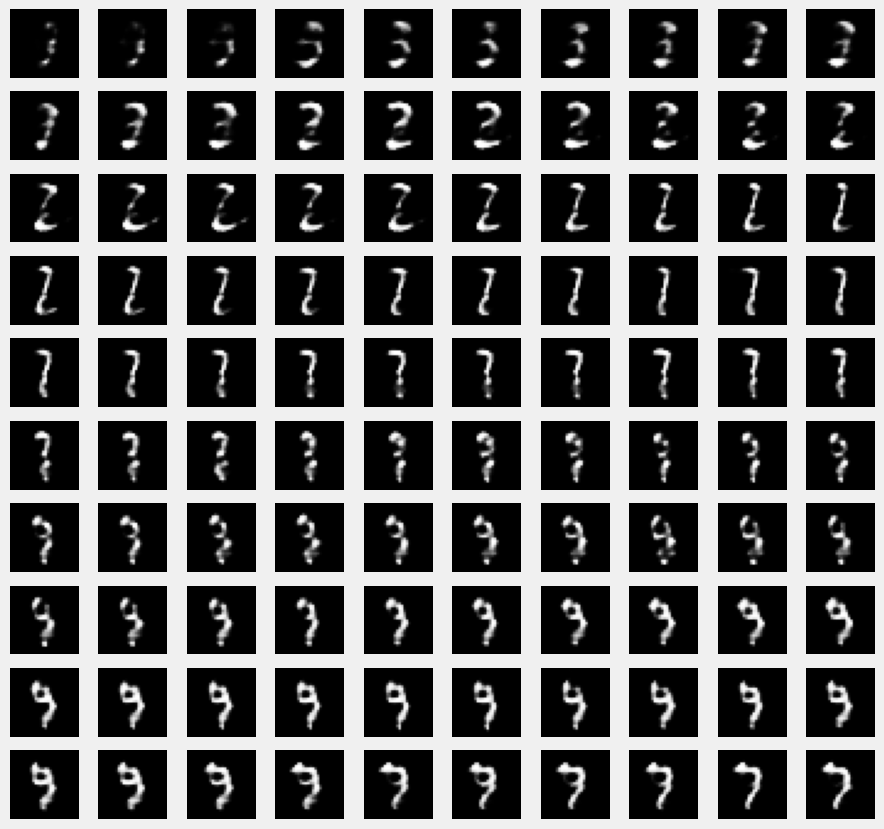

In [29]:
fig = plt.figure(figsize=(10, 10))
noise_len = noise_dim
for i in range(noise_len):
    noise_arr = [-1] * i + (noise_len - i) * [0]
    plt.subplot(10, 10, i+1)
    plt.imshow(generator(tf.constant([noise_arr]), training=False)[0, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

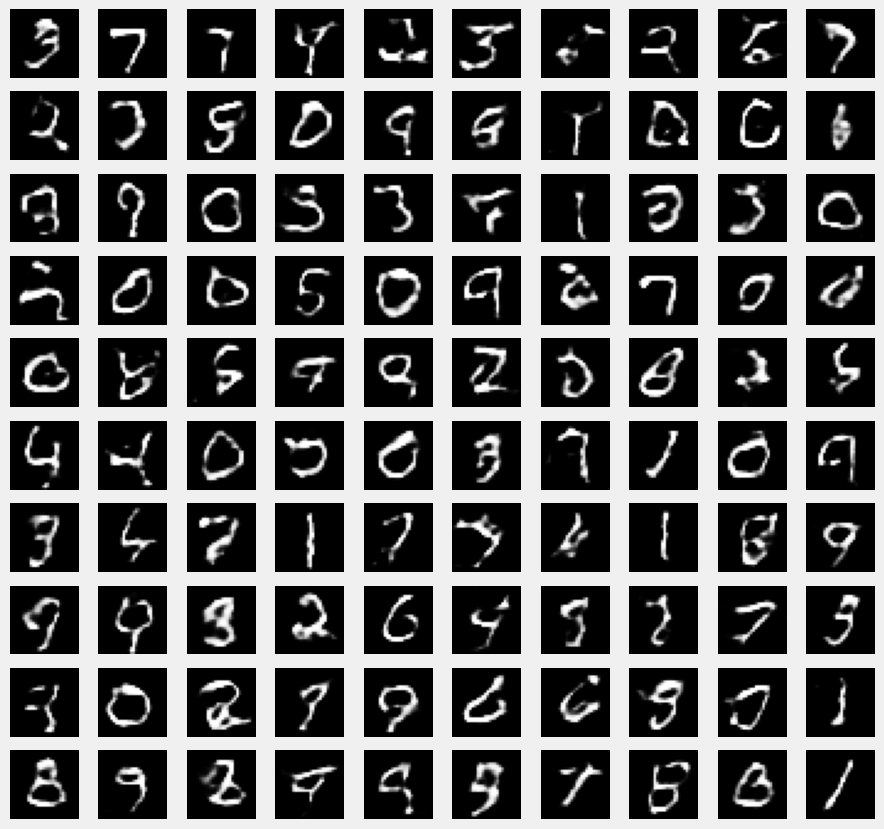

In [30]:
fig = plt.figure(figsize=(10, 10))
for i in range(noise_len):
    noise_arr = tf.random.normal([1, noise_dim])
    plt.subplot(10, 10, i+1)
    plt.imshow(generator(noise_arr, training=False)[0, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()